In [1]:
%matplotlib inline

In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F


plt.rcParams["savefig.bbox"] = "tight"
# sphinx_gallery_thumbnail_number = 2


def plot(imgs, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0])
    _, axs = plt.subplots(nrows=num_rows, ncols=num_cols, squeeze=False)
    for row_idx, row in enumerate(imgs):
        for col_idx, img in enumerate(row):
            ax = axs[row_idx, col_idx]
            img = F.to_pil_image(img.to("cpu"))
            ax.imshow(np.asarray(img), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    plt.tight_layout()

In [3]:
video_path =  "./data/short.mp4"

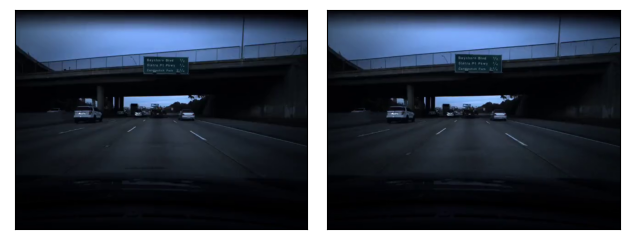

In [10]:
from torchvision.io import read_video
frames, _, _ = read_video(str(video_path), output_format="TCHW",pts_unit="sec")

img1_batch = torch.stack([frames[0], frames[1]])
img2_batch = torch.stack([frames[0], frames[1]])

plot(img1_batch)

In [12]:
from torchvision.models.optical_flow import Raft_Large_Weights

weights = Raft_Large_Weights.DEFAULT
transforms = weights.transforms()

def preprocess(img1_batch, img2_batch):
    return transforms(img1_batch, img2_batch)


img1_batch, img2_batch = preprocess(img1_batch, img2_batch)

print(f"shape = {img1_batch.shape}, dtype = {img1_batch.dtype}")


shape = torch.Size([2, 3, 480, 640]), dtype = torch.float32


In [13]:
from torchvision.models.optical_flow import raft_large

# If you can, run this example on a GPU, it will be a lot faster.
device = "cuda" if torch.cuda.is_available() else "cpu"

model = raft_large(weights=Raft_Large_Weights.DEFAULT, progress=False).to(device)
model = model.eval()

list_of_flows = model(img1_batch.to(device), img2_batch.to(device))
print(f"type = {type(list_of_flows)}")
print(f"length = {len(list_of_flows)} = number of iterations of the model")

type = <class 'list'>
length = 12 = number of iterations of the model


In [14]:
predicted_flows = list_of_flows[-1]
print(f"dtype = {predicted_flows.dtype}")
print(f"shape = {predicted_flows.shape} = (N, 2, H, W)")
print(f"min = {predicted_flows.min()}, max = {predicted_flows.max()}")

dtype = torch.float32
shape = torch.Size([2, 2, 480, 640]) = (N, 2, H, W)
min = -0.04644405096769333, max = 0.07622290402650833


# Optical Flow Image Genreration

***Warning:*** Generation will take 8 seconds per frame

In [16]:
from torchvision.io import write_jpeg
from pathlib import Path

# Setup path to image folder
output_folder = "flowdata/"
image_path = Path(output_folder)

if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

for i, (img1, img2) in enumerate(zip(frames, frames[1:])):
    # Note: it would be faster to predict batches of flows instead of individual flows
    img1, img2 = preprocess(img1, img2)

    list_of_flows = model(img1.to(device)[None,...], img2.to(device)[None,...])
    predicted_flow = list_of_flows[-1][0]
    flow_img = flow_to_image(predicted_flow).to("cpu")
    filename = output_folder + f"predicted_flow_{i}.jpg"
    write_jpeg(flow_img, filename)

Did not find flowdata directory, creating one...


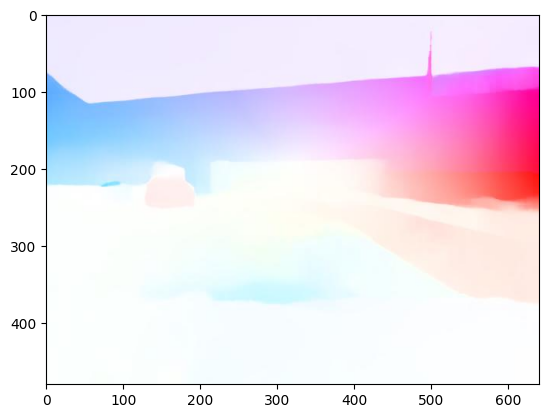

In [17]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

img = mpimg.imread('./flowdata/predicted_flow_0.jpg')
imgplot = plt.imshow(img)